#### Projects MAP 556
### Monte Carlo methods and stochastic processes
##### GNABEYEU MBIADA Emmanuel
##### Alioua Imrane 

## Variance Reduction Applied to Machine Learning for Pricing Bermudan/American Options in High Dimension

> we implement here by a backward dynamic programming algorithm, an efficient method to compute the price of multi-asset American options following a Black-Scholes dynamics, based on Machine Learning, Monte Carlo simulations and variance reduction technique. 

> The backward dynamic programming algorithm considers a finite number of uniformly distributed exercise dates. On these dates, the option value is computed as the maximum between the exercise value and the continuation value, which is obtained by means of Gaussian process regression technique and Monte Carlo simulations. 


> We will show that such a method performs well for low dimension baskets but it is not accurate for very high dimension baskets. In order to improve the dimension range and then  overcome the
problem of the curse of dimensionality, we employ the European option price as a control variate, which allows us to treat very large baskets and moreover to reduce the variance of price estimators. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm 
from scipy.stats import norm as scnorm
import plotly.graph_objects as go
from ipywidgets import interact, widgets
from scipy.stats import qmc
from scipy import linalg 
import scipy.optimize as opt

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

In [2]:
# Supressing the warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
T = 1
S_i = 100
K = 100
r = 0.05,
neta_i = 0.0 # equal (null) dividend rates ηi = 0.0, 
neta = 0.0
sigma_i = 0.2 # equal volatilities , 
rho_ij = 0.2 # equal correlations 
N = 10  # exercise dates. Moreover, we consider P = 250, 500 or 1000 points,
M = np.array([10**3, 10**4 or 10**5]) # Monte Carlo simulations 
Q = 10000  # points for the computation of the European prices with the GPR-EI formula.
P_range=np.array([250,500,1000])
d_range = [2, 5, 10, 20, 40, 100] # the dimension d, considering 

In [4]:
def variance(sigma_i,d):
    # compute sigma
    return np.array([sigma_i for _ in range(d)])

def sqrtmh(A):
    vals, vecs = linalg.eigh(A)
    return vecs @ np.diag(np.sqrt(vals)) @ vecs.T.conjugate()

def square_root_correlation_matrix(rho,d,sigma_i):
    # compute Gamma and it square gamma
    Gamma=rho*np.ones(d)+(1-rho)*np.eye(d)
    CorrMatrix=(sigma_i**2)*Gamma
    return sqrtmh(Gamma),CorrMatrix

$\sigma$

In [5]:
d=3
sigma_i=0.2
rho=0.2
Sigma=variance(sigma_i,d)
gamma=square_root_correlation_matrix(rho,d,sigma_i)[0]
gamma

array([[0.99069011, 0.09626292, 0.09626292],
       [0.09626292, 0.99069011, 0.09626292],
       [0.09626292, 0.09626292, 0.99069011]])

#### Geometric and Arithmetic Basket Put Options and  Maximum Call Option

In [6]:
class BasketOptions:
    def __init__(self, Spot , Strike: float ):
        self.S = Spot
        self.K = Strike
        
    def __Arithmetic_Basket_Put_Options__(self,S,K):
        """ S: array of side (d,1)
        """
        self.__init__(self, S , K )
        return np.maximum(self.K-self.S.mean(),0)
    
    def Call_Maximum_d_assets_American_option(self,S,K):
        """ S: array of side (d,1)
        """
        self.__init__(self, S , K )
        return np.maximum(self.S.max()-self.K,0)
    
    def Geometric_Basket_Put_Options(self,S,K):
        """ S: array of side (d,1)
        """
        self.__init__(self, S , K )
        prod=1
        d=self.S.shape[0]
        for i in range(d):
            prod*=S[i]
            u= K-prod**(1/d)
        return np.maximum(u,0)

    
def Geometric_Basket_Put_Options(S,K):
    """ S: array of side (d,1)
    """
    prod=1
    d=S.shape[0]
    for i in range(d):
        prod*=S[i]
    u= K-prod**(1/d)
    return np.maximum(u,0)

def Arithmetic_Basket_Put_Options(S,K):
    """ S: array of side (d,1)
    """
    u= K-S.mean()
    return np.maximum(u,0)


def Call_Maximum_d_assets_American_option(S,K):
    """ S: array of side (d,1)
    """
    u= S.max()-K
    return np.maximum(u,0)

In [7]:
S=np.array([102,103,204,302])
K=100
s= Call_Maximum_d_assets_American_option(S,K)
s

202

#### Kernel function: SquaredExponentialKernel

In [8]:
class SquaredExponentialKernel:
    def __init__(self, sigma_f: float = 1, length: float = 1):
        self.sigma_f = sigma_f
        self.length = length

    def __call__(self, argument_1: np.array, argument_2: np.array) -> float:
        return float(self.sigma_f *
                     np.exp(-(np.linalg.norm(argument_1 - argument_2)**2) /
                            (2 * self.length**2)))

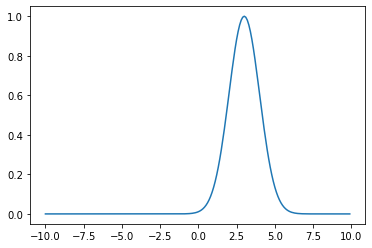

In [9]:
x_lines = np.arange(-10, 10, 0.1)
argument_2= 3  # argument_2=(-10, 10, 0.1)
kernel = SquaredExponentialKernel(length=1)
y_lines=np.array([kernel(x, argument_2) for x in x_lines]).reshape(-1,1)

plt.plot(x_lines,y_lines)

### Price of an European Call Options

In [10]:
def bs_function(S0, K, T, sigma, r):
    s = S0
    k = K*np.exp(-r*T)
    v = sigma*sigma*T
    base = np.log(s/k)/np.sqrt(v)
    dm, dp = (base - 0.5*np.sqrt(v), base + 0.5*np.sqrt(v))
    return S0*scnorm.cdf(dp) - k*scnorm.cdf(dm)

In [11]:
d=10
M=10**2
W=np.random.multivariate_normal(np.zeros(d),np.identity(d),size=M)
W.shape

(100, 10)

#### Optimisation of the Log-Likedlihood

>The minimize() function is shorthand for scipy.optimize.minimize(). This function returns a dictionary of objects including the solution to the optimization problem and whether the problem actually solved. The minimize function has three mandatory arguments, plus a lot of options. You can experiment with the options on the minimize() documentation page. 

>1. The first argument of the minimize function is the criterion function (crit() in this example) from which the minimize() function will test values of the parameters in searching for the minimum value.
>2. The second argument is an initial guess for the values of the parameters that minimize the criterion function crit().
>3. The third argument is the tuple of all the objects needed to solve the criterion function in crit().

In [12]:
def Compute_K(X,sigma_f,sigma_l):
    a=X.shape[0]
    K=np.zeros((a,a))
    for i in range(a):
        for j in range(a):
            K[i,j]= (sigma_f**2) * np.exp(-(np.linalg.norm(X[i] - X[j])**2) / (2 * sigma_l**2))
    return K

def log_lik_norm(X,y,sigma_f,sigma_l,sigma_p):
    K= Compute_K(X,sigma_f,sigma_l) 
    p=K.shape[0]
    A=K + (sigma_p**2)*np.identity(p)
    # assert(A.shape==p)
    log_lik_val =0.5*(np.log(np.linalg.det(A))+ y.T@(np.linalg.inv(A))@ y)
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

def crit(params,X,y): #, *args):
    '''
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (3,) vector, ([sigma_f,sigma_l,sigma_p])
    args   = length 2 tuple, (xvals, cutoff)

    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    '''
    # X,y =args
    sigma_f,sigma_l,sigma_p = params
    
    # y = args

    neg_log_lik_val = log_lik_norm(X,y,sigma_f,sigma_l,sigma_p)
    
    return neg_log_lik_val

In [17]:
## Example
d=2
M=10
sigma_l_init = np.random.uniform(0, 1)  
sigma_f_init=  np.random.uniform(0, 1)
sigma_p_init = np.random.uniform(0, 1)
params_init = np.array([sigma_f_init,sigma_l_init,sigma_p_init])

X=np.random.multivariate_normal(np.zeros(d),np.identity(d),size=M)
K=Compute_K(X,sigma_f_init,sigma_l_init)
y=np.random.multivariate_normal(np.zeros(K.shape[0]),(K+sigma_p_init**2)*np.identity(K.shape[0]))
y.shape

(10,)

In [18]:
neg_log_lik_val=crit(params_init,X,y)
neg_log_lik_val

-3.677543862597976

In [19]:
sigma_l_init = np.random.uniform(0, 1)  
sigma_f_init=  np.random.uniform(0, 1)
sigma_p_init = np.random.uniform(0, 1)

params_init = np.array([sigma_f_init,sigma_l_init,sigma_p_init])

# pts=(X,y)

mle_args = (X,y)
results = opt.minimize(crit, params_init, args=mle_args)

sigma_f_MLE, sigma_l_MLE,sigma_p_MLE  = results.x

print('sigma_f_MLE=', sigma_f_MLE, 'sigma_l_MLE=', sigma_l_MLE,'sigma_p_MLE=', sigma_p_MLE)

sigma_f_MLE= 5.342840814228643 sigma_l_MLE= 3.8271056701371333 sigma_p_MLE= 0.0036323981077430985


In [20]:
def ComputeSigma_lfp(X,y):
    # revoir l'initialisation
    sigma_l_init = np.random.uniform(0, 1)  
    sigma_f_init=  np.random.uniform(0, 1)
    sigma_p_init = np.random.uniform(0, 1)
    mle_args = (X,y)
    results = opt.minimize(crit, params_init, args=mle_args)
    sigma_f_MLE, sigma_l_MLE,sigma_p_MLE  = results.x
    return sigma_f_MLE, sigma_l_MLE,sigma_p_MLE

def GPR_approximation(X,y):
    sigma_l, sigma_f,sigma_p=ComputeSigma_lfp(X,y)
    kernel = (sigma_f**2)*RBF(sigma_l)
    
    gpr = GaussianProcessRegressor(kernel=kernel,
         random_state=0).fit(X, y)
    return gpr

In [23]:
a=ComputeSigma_lfp(X,y)
a

(5.342840814228643, 3.8271056701371333, 0.0036323981077430985)

In [24]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

sigma_f=a[0]
sigma_l=a[1]
sigma_p=a[2]
kernel=(sigma_f**2)*RBF(sigma_l)
gpr = GaussianProcessRegressor(kernel=kernel,
         random_state=0).fit(X, y)

gpr.score(X, y)
gpr.predict(X[:2,:], return_std=True)

params = gpr.kernel_.get_params()
params

{'k1': 0.869**2,
 'k2': RBF(length_scale=1e-05),
 'k1__constant_value': 0.7543044680596579,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 9.999999999999997e-06,
 'k2__length_scale_bounds': (1e-05, 100000.0)}

In [35]:
gpr.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__k1': 5.34**2,
 'kernel__k2': RBF(length_scale=3.83),
 'kernel__k1__constant_value': 28.545947966187395,
 'kernel__k1__constant_value_bounds': (1e-05, 100000.0),
 'kernel__k2__length_scale': 3.8271056701371333,
 'kernel__k2__length_scale_bounds': (1e-05, 100000.0),
 'kernel': 5.34**2 * RBF(length_scale=3.83),
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': 0}

#### Halton sequence

In [25]:
def  Halton_sequence_Rd(d,Q):
    """output: h shape (d,q) 
    """
    sampler = qmc.Halton(d=d, scramble=False) # seed=None
    sample = sampler.random(n=Q+1)[1:]
    return sample

In [26]:
d=3
Q=100
sample=Halton_sequence_Rd(d,Q)
sample.shape

(100, 3)

In [27]:
S0=np.array([100,100,100])
K=100
Neta=np.zeros(d)
Sigma=variance(sigma_i,d)
gamma=square_root_correlation_matrix(rho,d,sigma_i)[0]
gamma

array([[0.99069011, 0.09626292, 0.09626292],
       [0.09626292, 0.99069011, 0.09626292],
       [0.09626292, 0.09626292, 0.99069011]])

####  Choice of the set $X^n$
>here we use a deterministic space-filling sequence based on the Halton sequence

In [28]:
###############
def compute_x_n(S0,r,Neta, Sigma,gamma,tn,P): # For a fixed n
    """
    Compute set x_np for tn.
    Args:
        S0: spot price
        Neta: array of dividend
        r:interest rate
        Sigma:array of volatilities of assets
        gamma : square of the covariance matrix
        tn: time
        P: Cardinal of the set Xn
    Returns: X_n of shape (P,d)
    """
    d=S0.shape[0]
    X_n=[]
    sample=Halton_sequence_Rd(d,P)
    for p in range(P):
        hp=sample[p]
        # vectorilization over the coordinates d
        x=S0 * np.exp(r-Neta-0.5*(Sigma**2)*tn + np.sqrt(tn)*Sigma*gamma@norm.ppf(hp, loc=10, scale=2))
        X_n.append(x)
    return np.array(X_n)

In [29]:
norm.ppf([0,0,0], loc=10, scale=2)

array([-inf, -inf, -inf])

In [30]:
r=0.15
Xn=compute_x_n(S0,r,np.zeros(d), Sigma,gamma,tn=2,P=1000)
Xn

array([[ 2958.75883948,  2379.37340741,  1932.74150781],
       [ 2193.98017552,  3837.87119157,  2715.02326815],
       [ 4390.21567646,  1682.88560643,  3547.68457177],
       ...,
       [ 3200.14466753,  9024.01596494,  5486.40753954],
       [ 6769.11254898,  1149.30641853, 13076.55515153],
       [ 1285.2671002 ,  2059.43099468,   685.00676827]])

####  Choice of the set $X^n_p$

In [31]:
def compute_X_tilde_np(x_np,r,Neta, Sigma,gamma,DeltaT,M): # For a fixed n and a fixed p
    """
    Compute the profit and loss.
    
    Args:
        x_np: shape (d,1)
    Returns:
       X_tilde_np: shape (M,d)
     
    """
    d=x_np.shape[0]
    G=np.random.multivariate_normal(np.zeros(d),np.identity(d),size=M)
    X_tilde_np=[]
    for m in range(M):
        x= x_np * np.exp(r-Neta-0.5*(Sigma**2)*DeltaT + np.sqrt(DeltaT)*Sigma*gamma@G[m])
        X_tilde_np.append(x)
    return np.array(X_tilde_np)

In [32]:
p=12
Xnp_tilde=compute_X_tilde_np(Xn[p],r,Neta, Sigma,gamma,DeltaT=0.1,M=1000)
Xnp_tilde.shape

(1000, 3)

##  The GPR Monte Carlo Metho

In [33]:
N=10
times = np.linspace(0, T, N, endpoint=True)
times.shape

(10,)

>Let us introduce the GPR Monte Carlo approach. We approximate the price of an American option with the price of a Bermudan option on the same basket. Specifically, let N be the number of time steps and $\Delta t = \frac{T}{N}$ the time increment. 

>The discrete exercise dates are $t_n = n \Delta t $, as n = 1, . . . , N. If x represents the vector of the underlying prices at the exercise date $t_n$, then the price of the Bermudan option $v^{BM}$ is given by:$ v^{BM}(t_n,x) = max(\Phi(x), \mathbb{E}_{t_n,x}[e^{−r∆t}v(t_{n+1}, S_{t_{n+1}})])$ 

In [34]:
def GPR_MC_Method(func,S0,K,r,Neta, Sigma,gamma,N,T,P,M):
    # gamma is the squarre root of Gamma the Correlation Matrix
    # we can proceed by a backward computation of v_BM_tilde 
   
    times = np.linspace(0, T, N, endpoint=True)
    dt = T/N
    # first value n=N
    X_N=compute_x_n(S0,r,Neta, Sigma,gamma,T,P) # shape (P,d) ?
    v_BM=[]
    for p in range(P):
        v_BM.append(func(X_N[p],K)) 
    v_BM=np.array(v_BM) # shape(P,1)
    
    # second value n=N-1
    X_n=compute_x_n(S0,r,Neta, Sigma,gamma,times[N-1],P) # shape (P,d) ?
    
    v_BM_tilde=[] # the different approximation for each p
    for p in range(P):
        x_np=X_n[p]
        x_tilde_np=compute_X_tilde_np(x_np,r,Neta, Sigma,gamma,dt,M) # equivalent to S_tN (M,d)
        v_BM=0 # for the sum of samples via MC
        for m in range(M):
            v_BM+=func(x_tilde_np[m],K)
        v_BM_tilde.append(np.maximum(func(x_np,K),np.exp(-r*dt)*v_BM/M))
    v_BM_tilde=np.array(v_BM_tilde)
    
    # train a GPR
    gpr=GPR_approximation(X_n,v_BM_tilde)
        
    #intermadiate values
    for n in range(N-2,0,-1):
        X_n=compute_x_n(S0,r,Neta, Sigma,gamma,times[n],P) # (P,d)
        
        v_BM_tilde=[] # the different approximation for each p
        for p in range(P):
            x_np=X_n[p]
            x_tilde_np=compute_X_tilde_np(x_np,r,Neta, Sigma,gamma,dt,M) # equivalent to Stn+1(M,d)
            v_n=gpr.predict(x_tilde_np)
            v_BM_tilde.append(np.maximum(func(x_np,K),np.exp(-r*dt)*v_n.mean()))
        v_BM_tilde=np.array(v_BM_tilde) #.reshape(-1)
        # train a GPR
        print(n)
        gpr=GPR_approximation(X_n,v_BM_tilde)

    # and then initial value:
    x_tilde_0=compute_X_tilde_np(S0,r,Neta, Sigma,gamma,dt,M) # shape(M,d)
    v_=gpr.predict(x_tilde_0)  
    v_BM_tilde_0 = np.maximum(func(S0,K),np.exp(-r*dt)*v_.mean())
  
    return v_BM_tilde_0

In [497]:
T=2
N=10
P=250
M=100

func=Arithmetic_Basket_Put_Options #function.__Arithmetic_Basket_Put_Options__
times = np.linspace(0, T, N, endpoint=True)
dt = T/N

# first value n=N
X_N=compute_x_n(S0,r,Neta, Sigma,gamma,T,P) # shape (P,d) ?
v_BM_N=[]
for p in range(P):
    v_BM_N.append(func(X_N[p],K)) 
v_BM_N=np.array(v_BM_N) # shape(P,1)
    
# second value n=N-1
X_n=compute_x_n(S0,r,Neta, Sigma,gamma,times[N-1],P) # shape (P,d) ?
    
v_BM_tilde=[] # the different approximation for each p
for p in range(P):
    x_np=X_n[p]
    x_tilde_np=compute_X_tilde_np(x_np,r,Neta, Sigma,gamma,dt,M) # equivalent to S_tN (M,d)
    v_BM=0 # for the sum of samples via MC
    for m in range(M):
        v_BM+=func(x_tilde_np[m],K)
    v_BM_tilde.append(np.maximum(func(x_np,K),np.exp(-r*dt)*v_BM/M))
v_BM_tilde=np.array(v_BM_tilde)
    
# train a GPR
gpr=GPR_approximation(X_n,v_BM_tilde)
#intermadiate values
for n in range(N-2,0,-1):
    X_n=compute_x_n(S0,r,Neta, Sigma,gamma,times[n],P) # (P,d)
        
    v_BM_tilde=[] # the different approximation for each p
    for p in range(P):
        x_np=X_n[p]
        x_tilde_np=compute_X_tilde_np(x_np,r,Neta, Sigma,gamma,dt,M) # equivalent to Stn+1(M,d)
        v_n=0 # for the sum of samples via MC
        v_=gpr.predict(x_tilde_np)
        #for m in range(M):
        #    a=gpr.predict(x_tilde_np[m].reshape(1, -1))
        #    v_n+=a
        v_BM_tilde.append(np.maximum(func(x_np,K),np.exp(-r*dt)*v_.mean()))

    v_BM_tilde=np.array(v_BM_tilde) #.reshape(-1)
    print(v_BM_tilde)
    # train a GPR
    print(n)
    gpr=GPR_approximation(X_n,v_BM_tilde)

# and then initial value:
x_tilde_0=compute_X_tilde_np(S0,r,Neta, Sigma,gamma,dt,M) # shape(M,d)
v_=gpr.predict(x_tilde_0)  
v_BM_tilde_0 = np.maximum(func(S0,K),np.exp(-r*dt)*v_.mean())  
v_BM_tilde_0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0

0.0

In [439]:
v_BM_tilde.shape

(250,)

In [498]:
GPR_MC_Method(Arithmetic_Basket_Put_Options,S0,K,r,Neta, Sigma,gamma,N=10,T=2,P=250,M=100)

8
7
6
5
4
3
2
1


0.0

## The GPR Monte Carlo Control Variate 

>thod
Let us present the GPR Monte Carlo Control Variate method (GPR-MC-CV), that is our proposed algorithm.
The control variate technique is commonly used to reduce the variance of Monte Carlo estimators, but it can also give its contribution in American pricing.

>Let us consider an American and an European option with the same payoff function Ψ and maturity T , and let $v^{AM}$ , $v^{EU}$ denote their prices respectively. For a fixed time t and underlying stocks x, we define the American-European price gap
as: $v(t, x) = v^{AM}(t, x) − v^{EU}(t, x)$, then v (T, x) = 0.

> It is straightforward to see that $ v(t, x) = sup_{τ \in \mathbb{T}_{t,T}} \mathbb{E}_{t,x}[e^{−r(τ−t)}Ψ (τ, Sτ )]$ where $T_t$,T stands for the set of all stopping times taking values in $[t, T ]$ and Ψ is defined by $Ψ (t, x) = Ψ (x) − v^{EU}(t, x)$.

Let us consider a set $Z = {z^q, q = 1, . . . , Q}$ consisting of Q points in $R^d$ quasi-randomly distributed quasi-randomly distributed
according to the law of the vector $ (σ_1W_1^1, . . . , σ_dW_d^d)^T$

In particular, we define $z^q_i =\sqrt{T}σ_iΣ_ih^q$
where $Σ_i$ is i-th row of the matrix Σ and is i-th row of the matrix Σ and $h^q$
is the q-th point of the Halton sequence in $R^d$

In [44]:
# Helper function to calculate the respective covariance matrices
def cov_matrix(x1, x2, cov_function) -> np.array:
    return np.array([[cov_function(a, b) for a in x1] for b in x2])

def compute_Z(T,Sigma,gamma,Q):
    """ Sigma: (d,1)
         Covariance: (d,d)
    output: Z shape (d,q) 
    """
    Z=[]
    h=Halton_sequence_Rd(d,Q)
    for q in range(Q):
        h_q=h[q]
        z=np.sqrt(T)*Sigma*(gamma@norm.ppf(h_q, loc=10, scale=2))
        Z.append(Z)
    return np.array(Z)

In [ ]:
d=3
Q=100
Z=compute_Z(T,Sigma,gamma,Q)

In a nutshell, the main idea is to approximate the function u by training the GPR method on the set Z.
> we compute ω using the formular: $ w = (K(X,X) + σ^2_P I_P)^{−1}y$
By cholesky decomposition, we will have: $(K(X,X) + σ^2_P I_P)^{−1}=(LL^T)^{−1}=L^{-T}L^{-1}$ and then $ w =L^{-T}L^{-1}y$, if we set $L^{-1}y=m$,  to find w, we just need to solve the equation $L^Tw=y$

In [36]:
def approximation_u(func,S0,K,T,r,Neta,Sigma,gamma,Q):
    y=[]
    Z=compute_Z(T,Sigma,gamma,Q)
    for q in range(Q):
        z=Z[q]
        ST=S0*np.exp((r-Neta-0.5*(Sigma**2))*T+z)
        y.append(func(ST,K))
    y=np.array(y)
    sigma_f_MLE, sigma_l_MLE,sigma_p_MLE= ComputeSigma_lfp(Z,y)
    K= Compute_K(Z,sigma_f_MLE,sigma_l_MLE)  
    L = np.linalg.cholesky(K + sigma_p_ML*np.eye(Q))
    m = np.linalg.solve(L, y)
    w=np.linalg.solve(L.T, m)
    return w

In [39]:
T=2
N=10
P=250
M=100
func=Arithmetic_Basket_Put_Options
gpr=approximation_u(func,S0,K,T,r,Neta,Sigma,gamma,Q)

NameError: name 'compute_Z' is not defined

The value of a call option for a non-dividend-paying underlying stock in terms of the Black–Scholes parameters is:

 {\begin{aligned}C(S_{t},t)&=N(d_{1})S_{t}-N(d_{2})Ke^{-r(T-t)}\\d_{1}&={\frac {1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac {S_{t}}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)(T-t)\right]\\d_{2}&=d_{1}-\sigma {\sqrt {T-t}}\\\end{aligned}}} {\begin{aligned}C(S_{t},t)&=N(d_{1})S_{t}-N(d_{2})Ke^{-r(T-t)}\\d_{1}&={\frac {1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac {S_{t}}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)(T-t)\right]\\d_{2}&=d_{1}-\sigma {\sqrt {T-t}}\\\end{aligned}}}
The price of a corresponding put option based on put–call parity with discount factor  e^{-r(T-t)}}e^{{-r(T-t)} is:

 {\begin{aligned}P(S_{t},t)&=Ke^{-r(T-t)}-S_{t}+C(S_{t},t)\\&=N(-d_{2})Ke^{-r(T-t)}-N(-d_{1})S_{t}\end{aligned}}\,} {\begin{aligned}P(S_{t},t)&=Ke^{-r(T-t)}-S_{t}+C(S_{t},t)\\&=N(-d_{2})Ke^{-r(T-t)}-N(-d_{1})S_{t}\end{aligned}}\,}

In [ ]:
def pricing_EU_option(w,Q,CovMatrix,r,t,T,d,sigma_f,sigma_l):
    sum_=0
    for q in range(Q):
        sum_+= w[q]*np.exp(-0.5*(z-z_mean).T@np.linalg.inv((T-t)*CovMatrix+(sigma_l**2)*np.eye(d))@(z-z_mean))
    
    v= (sigma_f**2)*(sigma_l**d)*sum_ / np.linalg.det((T-t)*CovMatrix+(sigma_l**2)*np.eye(d))
    v_EU=np.exp(-r*(T-t))*v
    return v_EU

def phi_tilde(func,t,x,K):
    return func(x,K)-pricing_EU_option(w,P,r,t,T,d)


In [ ]:
def evaluation_GPR(w,X_npm):
    
    return w@kernel(X_npm)

def GPR_MC_CV_algorithm(func,S0,K,r,Neta, Sigma,gamma,N,T,P,M):
    # gamma is the squarre root of Gamma the Correlation Matrix
    # we can proceed by a backward computation of v_BM_tilde 
    
       times = np.linspace(0, T, N, endpoint=True)
    dt = T/N
    # first value n=N
    X_np= compute_x_np(S0,r,Neta, Sigma,Covariance,tn)
    X_tilde_np=compute_X_tilde_np(x_np,r,Neta, Sigma,Covariance,DeltaT,M)
    
    w=GPR_approximation(X,y)
    v_EU=pricing_EU_option(w,P,r,t,T,d) # for each tn ?
    
    
    #Step N-1:  shaping of v^GPR_n
    for p in range(P):
        y= phi_tilde(func,tN,X[N-1,p])
        w=GPR_approximation(X[p],y)
    
    # second value n=N-1
    X_n=compute_x_n(S0,r,Neta, Sigma,gamma,times[N-1],P) # shape (P,d) ?
    
    v_tilde=[] # the different approximation for each p
    
    for p in range(P):
        x_np=X_n[p]
        v_tilde.append(phi_tilde(func,times[N-1],x_np))
    v_BM_tilde=np.array(v_BM_tilde)
    # train a GPR
    gpr=GPR_approximation(X_n,v_BM_tilde)
            
    for n in range (N-2,0,-1):
        #Step n:
        X_n=compute_x_n(S0,r,Neta, Sigma,gamma,times[n],P) # (P,d)
        v_tilde=[] 
        for p in range(P):
            x_np=X_n[p]
            x_tilde_np=compute_X_tilde_np(x_np,r,Neta, Sigma,gamma,dt,M) # equivalent to Stn+1(M,d)
            v_n=gpr.predict(x_tilde_np)
        
            phi_=phi_tilde(func,times[n],x_np)
            right=(np.exp(-r*dt)/M) *np.sum(evaluation_GPR(w,x_tilde_np)) @@@
            v_tilde.append(np.maximum(phi,right))
        
        v_tilde=np.array(v_tilde) #.reshape(-1)
        # train a GPR
        print(n)
        gpr=GPR_approximation(X_n,v_tilde)

        
    #step 0
    x_tilde_0=compute_X_tilde_np(S0,r,Neta, Sigma,gamma,dt,M) # shape(M,d)
    v_=gpr.predict(x_tilde_0)  
    right= (np.exp(-r*dt)/M ) *v_.mean()
    v_tilde_0=np.maximun(func(S0,K),right)
    
    v_BM=v_tilde_0+pricing_EU_option(0,S0)
    return v_BM

In [7]:
# Helper function to calculate the respective covariance matrices
def cov_matrix(x1, x2, cov_function) -> np.array:
    return np.array([[cov_function(a, b) for a in x1] for b in x2])

In [24]:
x1=np.array([9,6,1,5])
x2=np.array([2,4,3,7])

x1.dot(x1.T)

143